Installing Dependencies

In [23]:
!pip3 install torchrl
!pip3 install gym[mujoco]
!pip3 install tqdm

In [24]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

# Define Hyperparameters

Depending on the resources available, one may choose to execute the policy on GPU or on another device. The frame_skip will control how for how many frames is a single action being executed. The rest of the arguments that count frames must be corrected for this value (since one environment step will actually return frame_skip frames).

In [50]:
device = "cpu" if not torch.has_cuda else "cuda:0"
num_cells =256 # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

Data collection parameters

When collecting data, we will be able to choose how big each batch will be by defining a frames_per_batch parameter. We will also define how many frames (such as the number of interactions with the simulator) we will allow ourselves to use. In general, the goal of an RL algorithm is to learn to solve the task as fast as it can in terms of environment interactions: the lower the total_frames the better. We also define a frame_skip: in some contexts, repeating the same action multiple times over the course of a trajectory may be beneficial as it makes the behavior more consistent and less erratic. However, “skipping” too many frames will hamper training by reducing the reactivity of the actor to observation changes.

When using frame_skip it is good practice to correct the other frame counts by the number of frames we are grouping together. If we configure a total count of X frames for training but use a frame_skip of Y, we will be actually collecting XY frames in total which exceeds our predefined budget.

In [26]:
frame_skip = 1
frames_per_batch = 1000 // frame_skip
# For a complete training, bri_skip
total_frames = 50_000 // frame_skip

# PPO parameters

At each data collection (or batch collection) we will run the optimization over a certain number of epochs, each time consuming the entire data we just acquired in a nested training loop. Here, the sub_batch_size is different from the frames_per_batch here above: recall that we are working with a “batch of data” coming from our collector, which size is defined by frames_per_batch, and that we will further split in smaller sub-batches during the inner training loop. The size of these sub-batches is controlled by sub_batch_size.

In [27]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

# Define an environment

in RL, an environment is usually the way we refer toa simulator or a control system. Various libraries provide simulation environments for reinforcement learning, including Gymnasium (previously OpenAI Gym), DeepMind Control Suite, and many others. As general library, TorchRL's goal is to provide an interchangeable interface to a large panel or RL simulators, allowing you to easily swap one environment whit another. For example creatting a wrapped gym environment can be achived with few characters:

In [28]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device, frame_skip=frame_skip)

In [29]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(in_keys=["observation"]),
        StepCounter(),
    ),
)

In [30]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

In [31]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


In [32]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
         shape=torch.Size([11]), space=None, device=cuda:0, dtype=torch.float32, domain=continuous),
    step_count: UnboundedDiscreteTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True), maximum=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True)), device=cuda:0, dtype=torch.int64, domain=continuous), device=cuda:0, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
     shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)), device=cuda:0, dtype=torch.float32, domain=continuous)
input_spec: CompositeSpec(
    action: BoundedTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(

the check_env_specs() function runs a small rollout and compares its output against the environment specs. If no error is raised, we can be confident that the specs are properly defined:

In [33]:
check_env_specs(env)

check_env_specs succeeded!


In [34]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
                reward: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.int64, is_shared=True)},
            batch_size=torch.Size([3]),
            device=cuda:0,
            is_shared=True),
        observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([3, 1]), devi

# Policy

PPO utilizes a stochastic policy to handle exploration. This means that our neural network will have to output the parameters of a distribution, rather than a single value corresponding to the action taken.

As the data is continuous, we use a Tanh-Normal distribution to respect the action space boundaries. TorchRL provides such distribution, and the only thing we need to care about is to build a neural network that outputs the right number of parameters for the policy to work with (a location, or mean, and a scale):

In [35]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


To enable the policy to “talk” with the environment through the tensordict data carrier, we wrap the nn.Module in a TensorDictModule. This class will simply ready the in_keys it is provided with and write the outputs in-place at the registered out_keys.

In [36]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

We now need to build a distribution out of the location and scale of our normal distribution. To do so, we instruct the ProbabilisticActor class to build a TanhNormal out of the location and scale parameters. We also provide the minimum and maximum values of this distribution, which we gather from the environment specs.

The name of the in_keys (and hence the name of the out_keys from the TensorDictModule above) cannot be set to any value one may like, as the TanhNormal distribution constructor will expect the loc and scale keyword arguments. That being said, ProbabilisticActor also accepts Dict[str, str] typed in_keys where the key-value pair indicates what in_key string should be used for every keyword argument that is to be used.

In [37]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

# Value Network

The value network is a crucial component of the PPO algorithm, even though it won’t be used at inference time. This module will read the observations and return an estimation of the discounted return for the following trajectory. This allows us to amortize learning by relying on the some utility estimation that is learned on-the-fly during training. Our value network share the same structure as the policy, but for simplicity we assign it its own set of parameters.

In [38]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

the usage of TensorDictModule makes it possible to directly read the output of the environment to run these modules, as they know what information to read and where to write it:

In [39]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_shared=True)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), de

# Data collector

TorchRL provides a set of DataCollector classes. Briefly, these classes execute three operations: reset an environment, compute an action given the latest observation, execute a step in the environment, and repeat the last two steps until the environment signals a stop (or reaches a done state).

They allow you to control how many frames to collect at each iteration (through the frames_per_batch parameter), when to reset the environment (through the max_frames_per_traj argument), on which device the policy should be executed, etc. They are also designed to work efficiently with batched and multiprocessed environments.

The simplest data collector is the SyncDataCollector: it is an iterator that you can use to get batches of data of a given length, and that will stop once a total number of frames (total_frames) have been collected. Other data collectors (MultiSyncDataCollector and MultiaSyncDataCollector) will execute the same operations in synchronous and asynchronous manner over a set of multiprocessed workers.

As for the policy and environment before, the data collector will return TensorDict instances with a total number of elements that will match frames_per_batch. Using TensorDict to pass data to the training loop allows you to write data loading pipelines that are 100% oblivious to the actual specificities of the rollout content.

In [40]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

# Replay buffer

Replay buffers are a common building piece of off-policy RL algorithms. In on-policy contexts, a replay buffer is refilled every time a batch of data is collected, and its data is repeatedly consumed for a certain number of epochs.

TorchRL’s replay buffers are built using a common container ReplayBuffer which takes as argument the components of the buffer: a storage, a writer, a sampler and possibly some transforms. Only the storage (which indicates the replay buffer capacity) is mandatory. We also specify a sampler without repetition to avoid sampling multiple times the same item in one epoch. Using a replay buffer for PPO is not mandatory and we could simply sample the sub-batches from the collected batch, but using these classes make it easy for us to build the inner training loop in a reproducible way.

In [41]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# Loss function

The PPO loss can be directly imported from TorchRL for convenience using the ClipPPOLoss class. This is the easiest way of utilizing PPO: it hides away the mathematical operations of PPO and the control flow that goes with it.

PPO requires some “advantage estimation” to be computed. In short, an advantage is a value that reflects an expectancy over the return value while dealing with the bias / variance tradeoff. To compute the advantage, one just needs to (1) build the advantage module, which utilizes our value operator, and (2) pass each batch of data through it before each epoch. The GAE module will update the input tensordict with new "advantage" and "value_target" entries. The "value_target" is a gradient-free tensor that represents the empirical value that the value network should represent with the input observation. Both of these will be used by ClipPPOLoss to return the policy and value losses.

In [48]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

# Training loop

We now have all the pieces needed to code our training loop. The steps include:

Collect data

Compute advantage:

- Loop over the collected to compute loss values
- Back propagate
- Optimize
- Repeat

Repeat:

- Repeat

In [51]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_mode("mean"), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

  2%|▏         | 1000/50000 [00:06<05:37, 145.13it/s]/usr/local/lib/python3.10/dist-packages/tensordict/nn/probabilistic.py:79: DeprecationWarning: set_interaction_mode is deprecated for naming clarity. Please use set_interaction_type with InteractionType enum instead.
  _insert_interaction_mode_deprecation_warning("set_")
eval cumulative reward:  587.8199 (init:  92.1421), eval step-count: 62, average reward= 9.3153 (init= 9.0866), step count (max): 96, lr policy:  0.0000: 100%|██████████| 50000/50000 [04:39<00:00, 179.42it/s] 

# Result

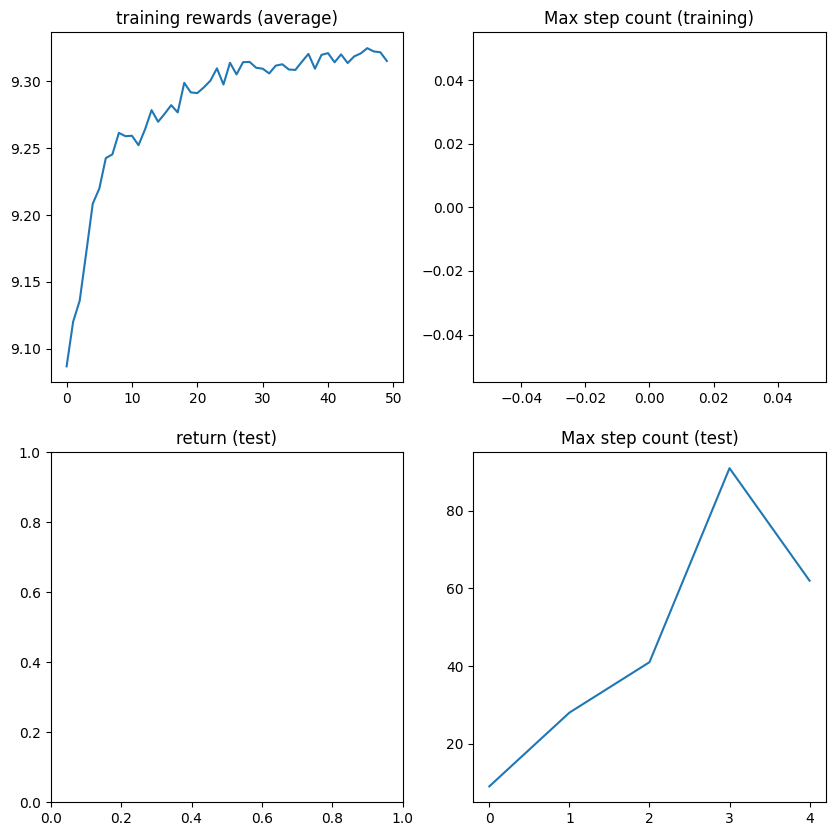

In [52]:
plt.figure(figsize =(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.title("return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()